In [80]:
# Importing the required libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve
import itertools

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [81]:
'''Setting up the env'''

TRAIN_DIR = './TrainData'
TEST_DIR = './TestData'

IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
LR = 1e-3


'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'XrayImagesToCovidPrediction-{}-{}.model'.format(LR, '6conv-basic') 

data_dir = pathlib.Path(TRAIN_DIR)
test_dir = pathlib.Path(TEST_DIR)
print(data_dir)
train_image_count = len(list(data_dir.glob('*/*.png')))

test_image_count = len(list(test_dir.glob('*/*.*')))

print(train_image_count)
print(test_dir)
print(test_image_count)

/content/x_ray_project/TrainData
1560
/content/x_ray_project/TestData
338


In [82]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 1560 files belonging to 2 classes.


In [83]:
print(train_ds.class_names)
class_names = train_ds.class_names

['negative', 'positive']


In [84]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 338 files belonging to 2 classes.


In [85]:
IMG_HEIGHT = 180
IMG_WIDTH = 180
BATCH_SIZE = 32
train_datagen =keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(data_dir,target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

val_generator = test_datagen.flow_from_directory(test_dir,target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE)

Found 1560 images belonging to 2 classes.
Found 338 images belonging to 2 classes.


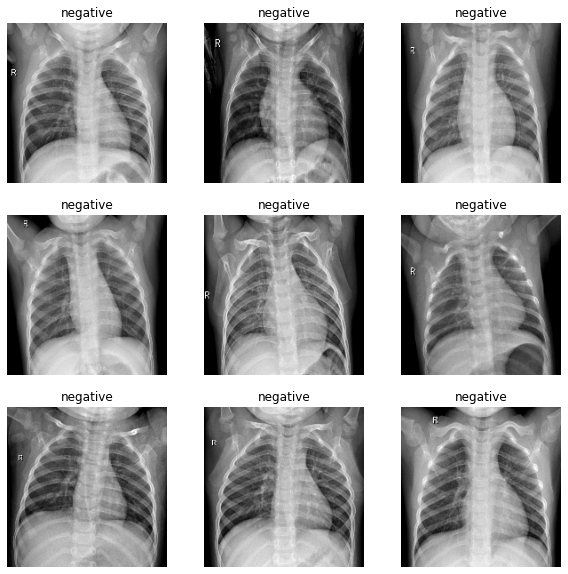

In [86]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [87]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [88]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [89]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [90]:
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [91]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [92]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [93]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
49/49 [==============================] - 6s 118ms/step - loss: 0.2976 - accuracy: 0.9186 - val_loss: 0.9703 - val_accuracy: 0.5740
Epoch 2/10
49/49 [==============================] - 1s 20ms/step - loss: 0.0693 - accuracy: 0.9724 - val_loss: 1.0887 - val_accuracy: 0.5799
Epoch 3/10
49/49 [==============================] - 1s 19ms/step - loss: 0.0526 - accuracy: 0.9827 - val_loss: 1.0755 - val_accuracy: 0.5799
Epoch 4/10
49/49 [==============================] - 1s 19ms/step - loss: 0.0348 - accuracy: 0.9897 - val_loss: 1.8315 - val_accuracy: 0.5562
Epoch 5/10
49/49 [==============================] - 1s 19ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 2.1000 - val_accuracy: 0.5828
Epoch 6/10
49/49 [==============================] - 1s 19ms/step - loss: 0.0190 - accuracy: 0.9955 - val_loss: 1.5232 - val_accuracy: 0.5710
Epoch 7/10
49/49 [==============================] - 1s 19ms/step - loss: 0.0106 - accuracy: 0.9974 - val_loss: 2.2705 - val_accuracy: 0.5651
Epoch 8/10
4

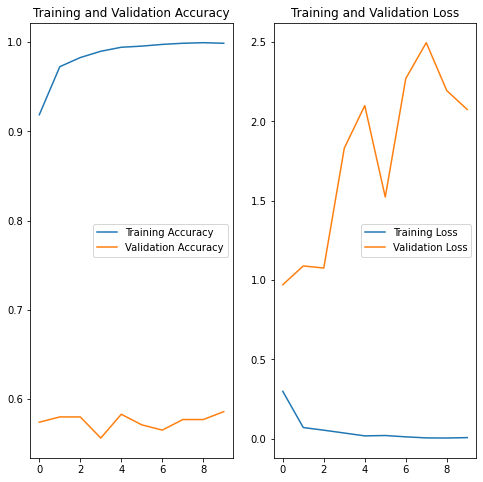

In [95]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
Y_pred = model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(val_generator.classes, y_pred)
print(cm)

Confusion Matrix
[[  0 158]
 [  0 180]]


In [97]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [98]:
cm_plot_labels = ['positive','negative']


Confusion matrix, without normalization
[[  0 158]
 [  0 180]]


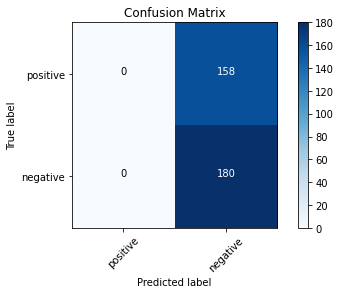

In [99]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [100]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

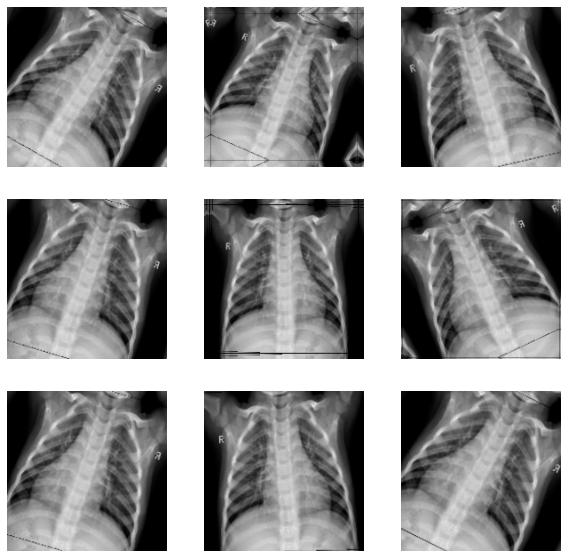

In [101]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [102]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [103]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 64)       

In [104]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
49/49 [==============================] - 1s 22ms/step - loss: 0.0137 - accuracy: 0.9923 - val_loss: 2.1468 - val_accuracy: 0.5710
Epoch 2/15
49/49 [==============================] - 1s 19ms/step - loss: 0.0057 - accuracy: 0.9994 - val_loss: 2.3938 - val_accuracy: 0.5680
Epoch 3/15
49/49 [==============================] - 1s 19ms/step - loss: 0.0046 - accuracy: 0.9974 - val_loss: 2.8365 - val_accuracy: 0.5828
Epoch 4/15
49/49 [==============================] - 1s 19ms/step - loss: 5.6717e-04 - accuracy: 1.0000 - val_loss: 3.3581 - val_accuracy: 0.5680
Epoch 5/15
49/49 [==============================] - 1s 19ms/step - loss: 8.8475e-05 - accuracy: 1.0000 - val_loss: 3.6196 - val_accuracy: 0.5651
Epoch 6/15
49/49 [==============================] - 1s 20ms/step - loss: 4.3170e-05 - accuracy: 1.0000 - val_loss: 3.8172 - val_accuracy: 0.5651
Epoch 7/15
49/49 [==============================] - 1s 19ms/step - loss: 2.8296e-05 - accuracy: 1.0000 - val_loss: 3.9504 - val_accuracy: 0.56

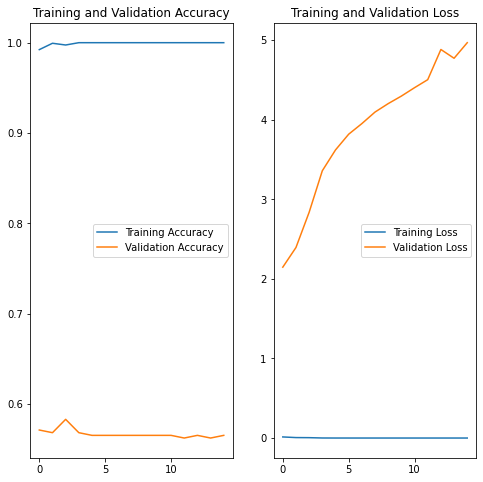

In [106]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center right')
plt.title('Training and Validation Loss')
plt.show()

In [108]:
#test_dir = pathlib.Path(TEST_DIR)
test_neg = '.TestData/CR.1.2.840.113564.192168196.2020031913094890017.1203801020003.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to negative with a 98.81 percent confidence.


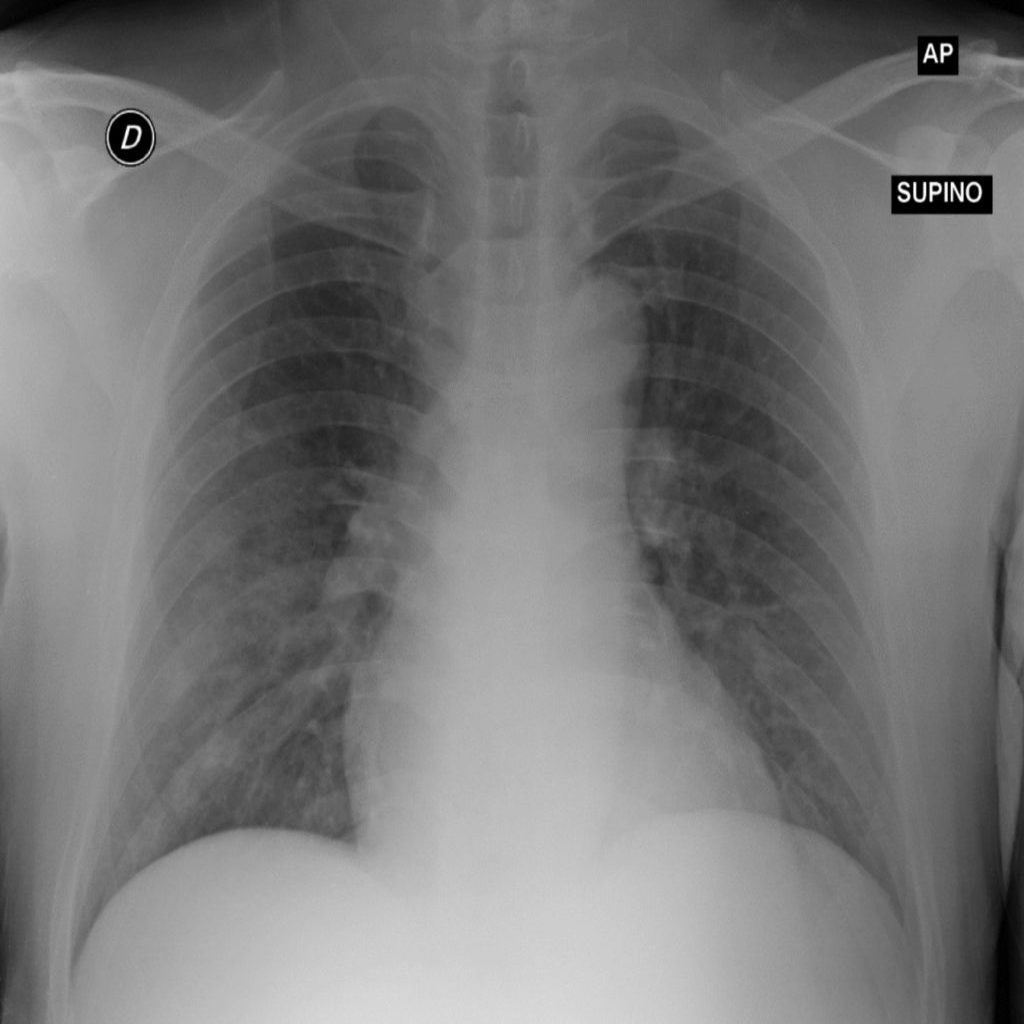

In [109]:
pos = list(data_dir.glob('positive/*'))
PIL.Image.open(str(pos[0]))

In [110]:
test_neg = '.TestData/CR.1.2.840.113564.1722810170.202003211940047348.1003000225002.png'
img = keras.preprocessing.image.load_img(
    test_neg
    , target_size=(IMG_HEIGHT, IMG_WIDTH)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to positive with a 100.00 percent confidence.
